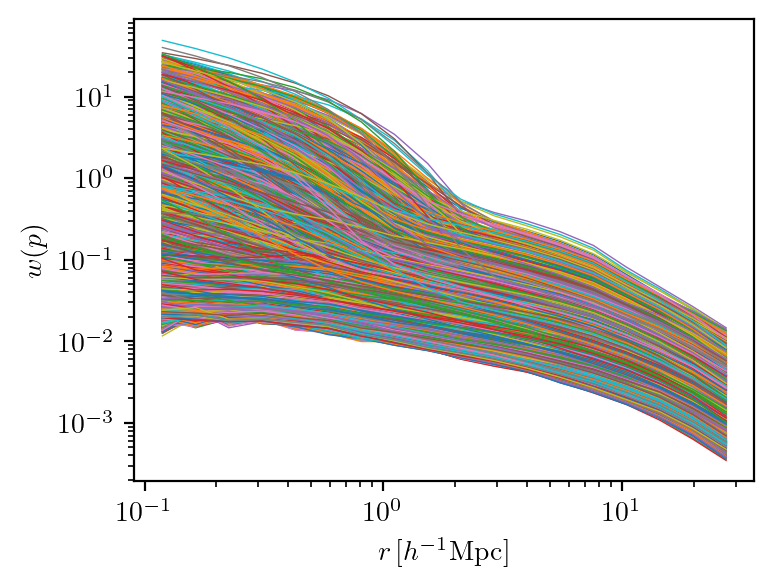

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from pycorr import TwoPointCorrelationFunction
import numpy as np
from astropy.stats import sigma_clip
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# cosmos = list(range(0, 5)) + list(range(13, 14)) + list(range(100, 127)) + list(range(130, 182))
cosmos = list(range(130, 182))
hods = list(range(100))


fig, ax = plt.subplots(figsize=(4, 3))

data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wp/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
data_fn = Path(data_dir) / f'wp_lhc.npy'
data = np.load(data_fn, allow_pickle=True).item()
r_p = data['r_p']
lhc_x = data['lhc_x']
lhc_y = data['lhc_y']

for i, cosmo in enumerate(cosmos):
    for j, hod in enumerate(hods):
        idx = i * 100 + j
        ax.plot(r_p, lhc_y[idx], lw=0.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$')
ax.set_ylabel('$w(p$)')
plt.show()

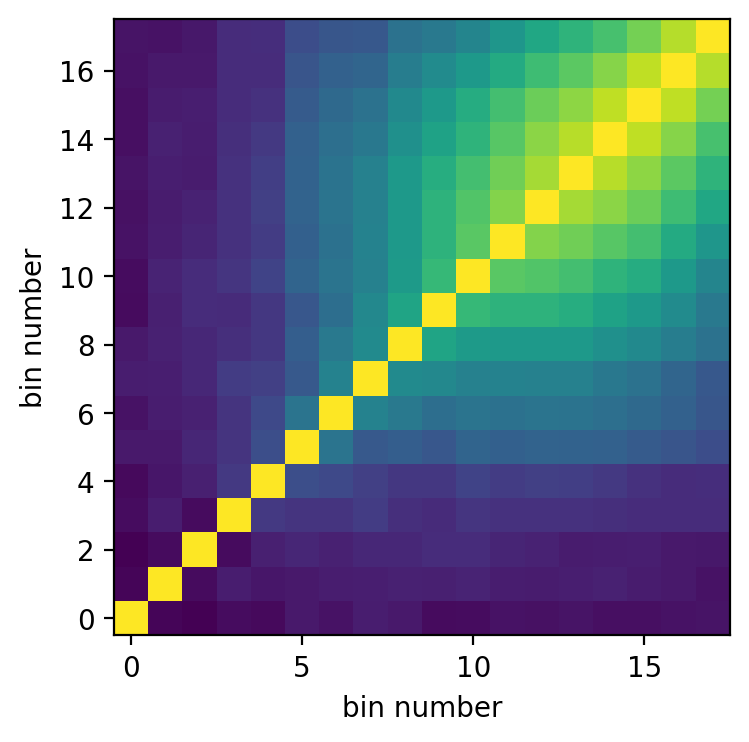

Loaded LHC with shape: (8500, 20), (8500, 18)


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from pycorr import TwoPointCorrelationFunction
import numpy as np
import pandas as pd
from astropy.stats import sigma_clip
%matplotlib inline
%config InlineBackend.figure_format='retina'

def read_covariance():
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wp/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'wp_lhc.npy'
    y = np.load(data_fn, allow_pickle=True).item()['cov_y']
    prefactor = 1 / 64
    cov = prefactor * np.cov(y, rowvar=False)
    corr = np.corrcoef(y, rowvar=False)
    return cov, corr

def read_lhc():
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wp/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'wp_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x']
    lhc_y = data['lhc_y']
    return lhc_x, lhc_y

covariance_matrix, correlation_matrix = read_covariance()

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(correlation_matrix, origin='lower')
ax.set_xlabel('bin number')
ax.set_ylabel('bin number')
plt.show()

lhc_x, lhc_y = read_lhc()
# lhc_y = lhc_y * np.std(lhc_y, axis=0) + np.mean(lhc_y, axis=0) 
print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')

Transforming output


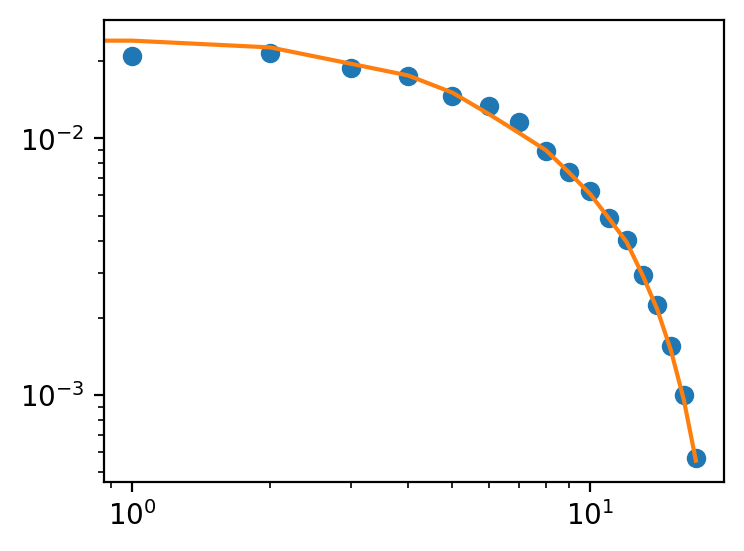

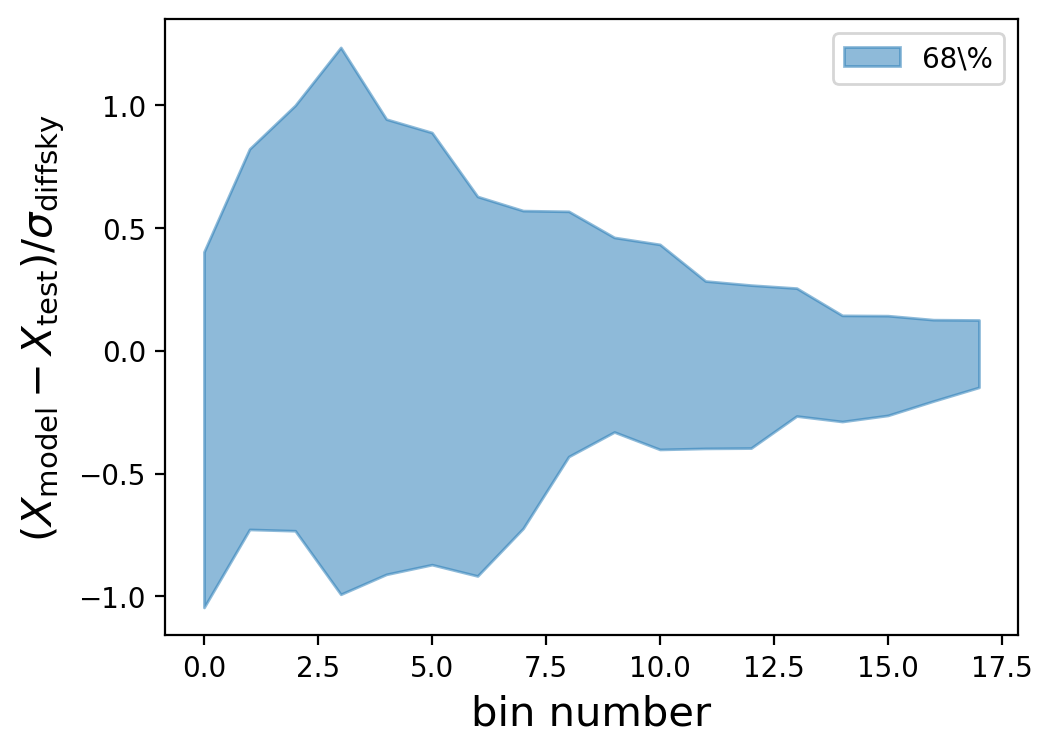

In [2]:
import glob
from sunbird.emulators import FCN
import torch

ntot = len(lhc_y)
q68_all = []
q95_all = []
emuerr_all = []
emulator_error_all = []
idx_train = list(range(600, ntot))
idx_test = list(range(600))

lhc_train_x = lhc_x[idx_train]
lhc_train_y = lhc_y[idx_train]
lhc_test_x = lhc_x[idx_test]
lhc_test_y = lhc_y[idx_test]

checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/wp/cosmo+hod/jul10_trans/last-v30.ckpt'
model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
model.eval()

with torch.no_grad():
    pred_test_y = model.get_prediction(torch.Tensor(lhc_test_x))
    pred_test_y = pred_test_y.numpy()


emulator_error = (pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix))
# emulator_error = (pred_test_y - lhc_test_y)/lhc_test_y
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

q68_all.append(q68)
q95_all.append(q95)
emulator_error_all.append((pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix)))
# emulator_error_all.append((pred_test_y - lhc_test_y)/lhc_test_y)
emuerr_all.append(pred_test_y - lhc_test_y)

fig, ax = plt.subplots(figsize=(4, 3))
idx = 449
ax.plot(lhc_test_y[idx], marker='o', ls='')
ax.plot(pred_test_y[idx])
ax.set_xscale('log')
ax.set_yscale('log')
    
# q68_all = np.array(q68_all).mean(axis=0)
# q95_all = np.array(q95_all).mean(axis=0)
emulator_error_all = np.concatenate(emulator_error_all)
q68_all = np.quantile(emulator_error_all, [0.16, 0.84], axis=0)
q95_all = np.quantile(emulator_error_all, [0.025, 0.975], axis=0)
emu_cov = np.cov(emulator_error_all, rowvar=False)
                      
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.fill_between(list(range(emulator_error.shape[1])), q68_all[0], q68_all[1], alpha=0.5, label='68\%', color='C0')
# ax.fill_between(list(range(emulator_error.shape[1])), q95_all[0], q95_all[1], alpha=0.5, label='95\%', color='C1')
ax.legend()
ax.set_xlabel('bin number', fontsize=15)
ax.set_ylabel('(model - test)/sigma', fontsize=15)
ax.set_ylabel(r'$(X_{\rm model} - X_{\rm test})/\sigma_{\rm diffsky}$', fontsize=15)
# plt.ylim(-0.1,0.1)
# ax.fill_between(list(range(len(s)), q68_all[0], q68_all[1], alpha=0.5, color='crimson'))
plt.show()

['omega_b', 'omega_cdm', 'sigma8_m', 'n_s', 'nrun', 'N_ur', 'w0_fld', 'wa_fld', 'logM_cut', 'logM_1', 'sigma', 'alpha', 'kappa', 'alpha_c', 'alpha_s', 's', 'A_cen', 'A_sat', 'B_cen', 'B_sat']
Loaded LHC with shape: (8500, 20), (8500, 100)
['B_cen' 'B_sat' 'alpha' 'alpha_c' 'alpha_s' 'kappa' 'logM_1' 'logM_cut'
 'n_s' 'omega_cdm' 'sigma' 'sigma8_m']
Removed no burn in
['omega_b', 'omega_cdm', 'sigma8_m', 'n_s', 'nrun', 'N_ur', 'w0_fld', 'wa_fld', 'logM_cut', 'logM_1', 'sigma', 'alpha', 'kappa', 'alpha_c', 'alpha_s', 's', 'A_cen', 'A_sat', 'B_cen', 'B_sat']
Loaded LHC with shape: (8500, 20), (8500, 100)
['B_cen' 'B_sat' 'alpha' 'alpha_c' 'alpha_s' 'kappa' 'logM_1' 'logM_cut'
 'n_s' 'omega_cdm' 'sigma' 'sigma8_m']
Removed no burn in


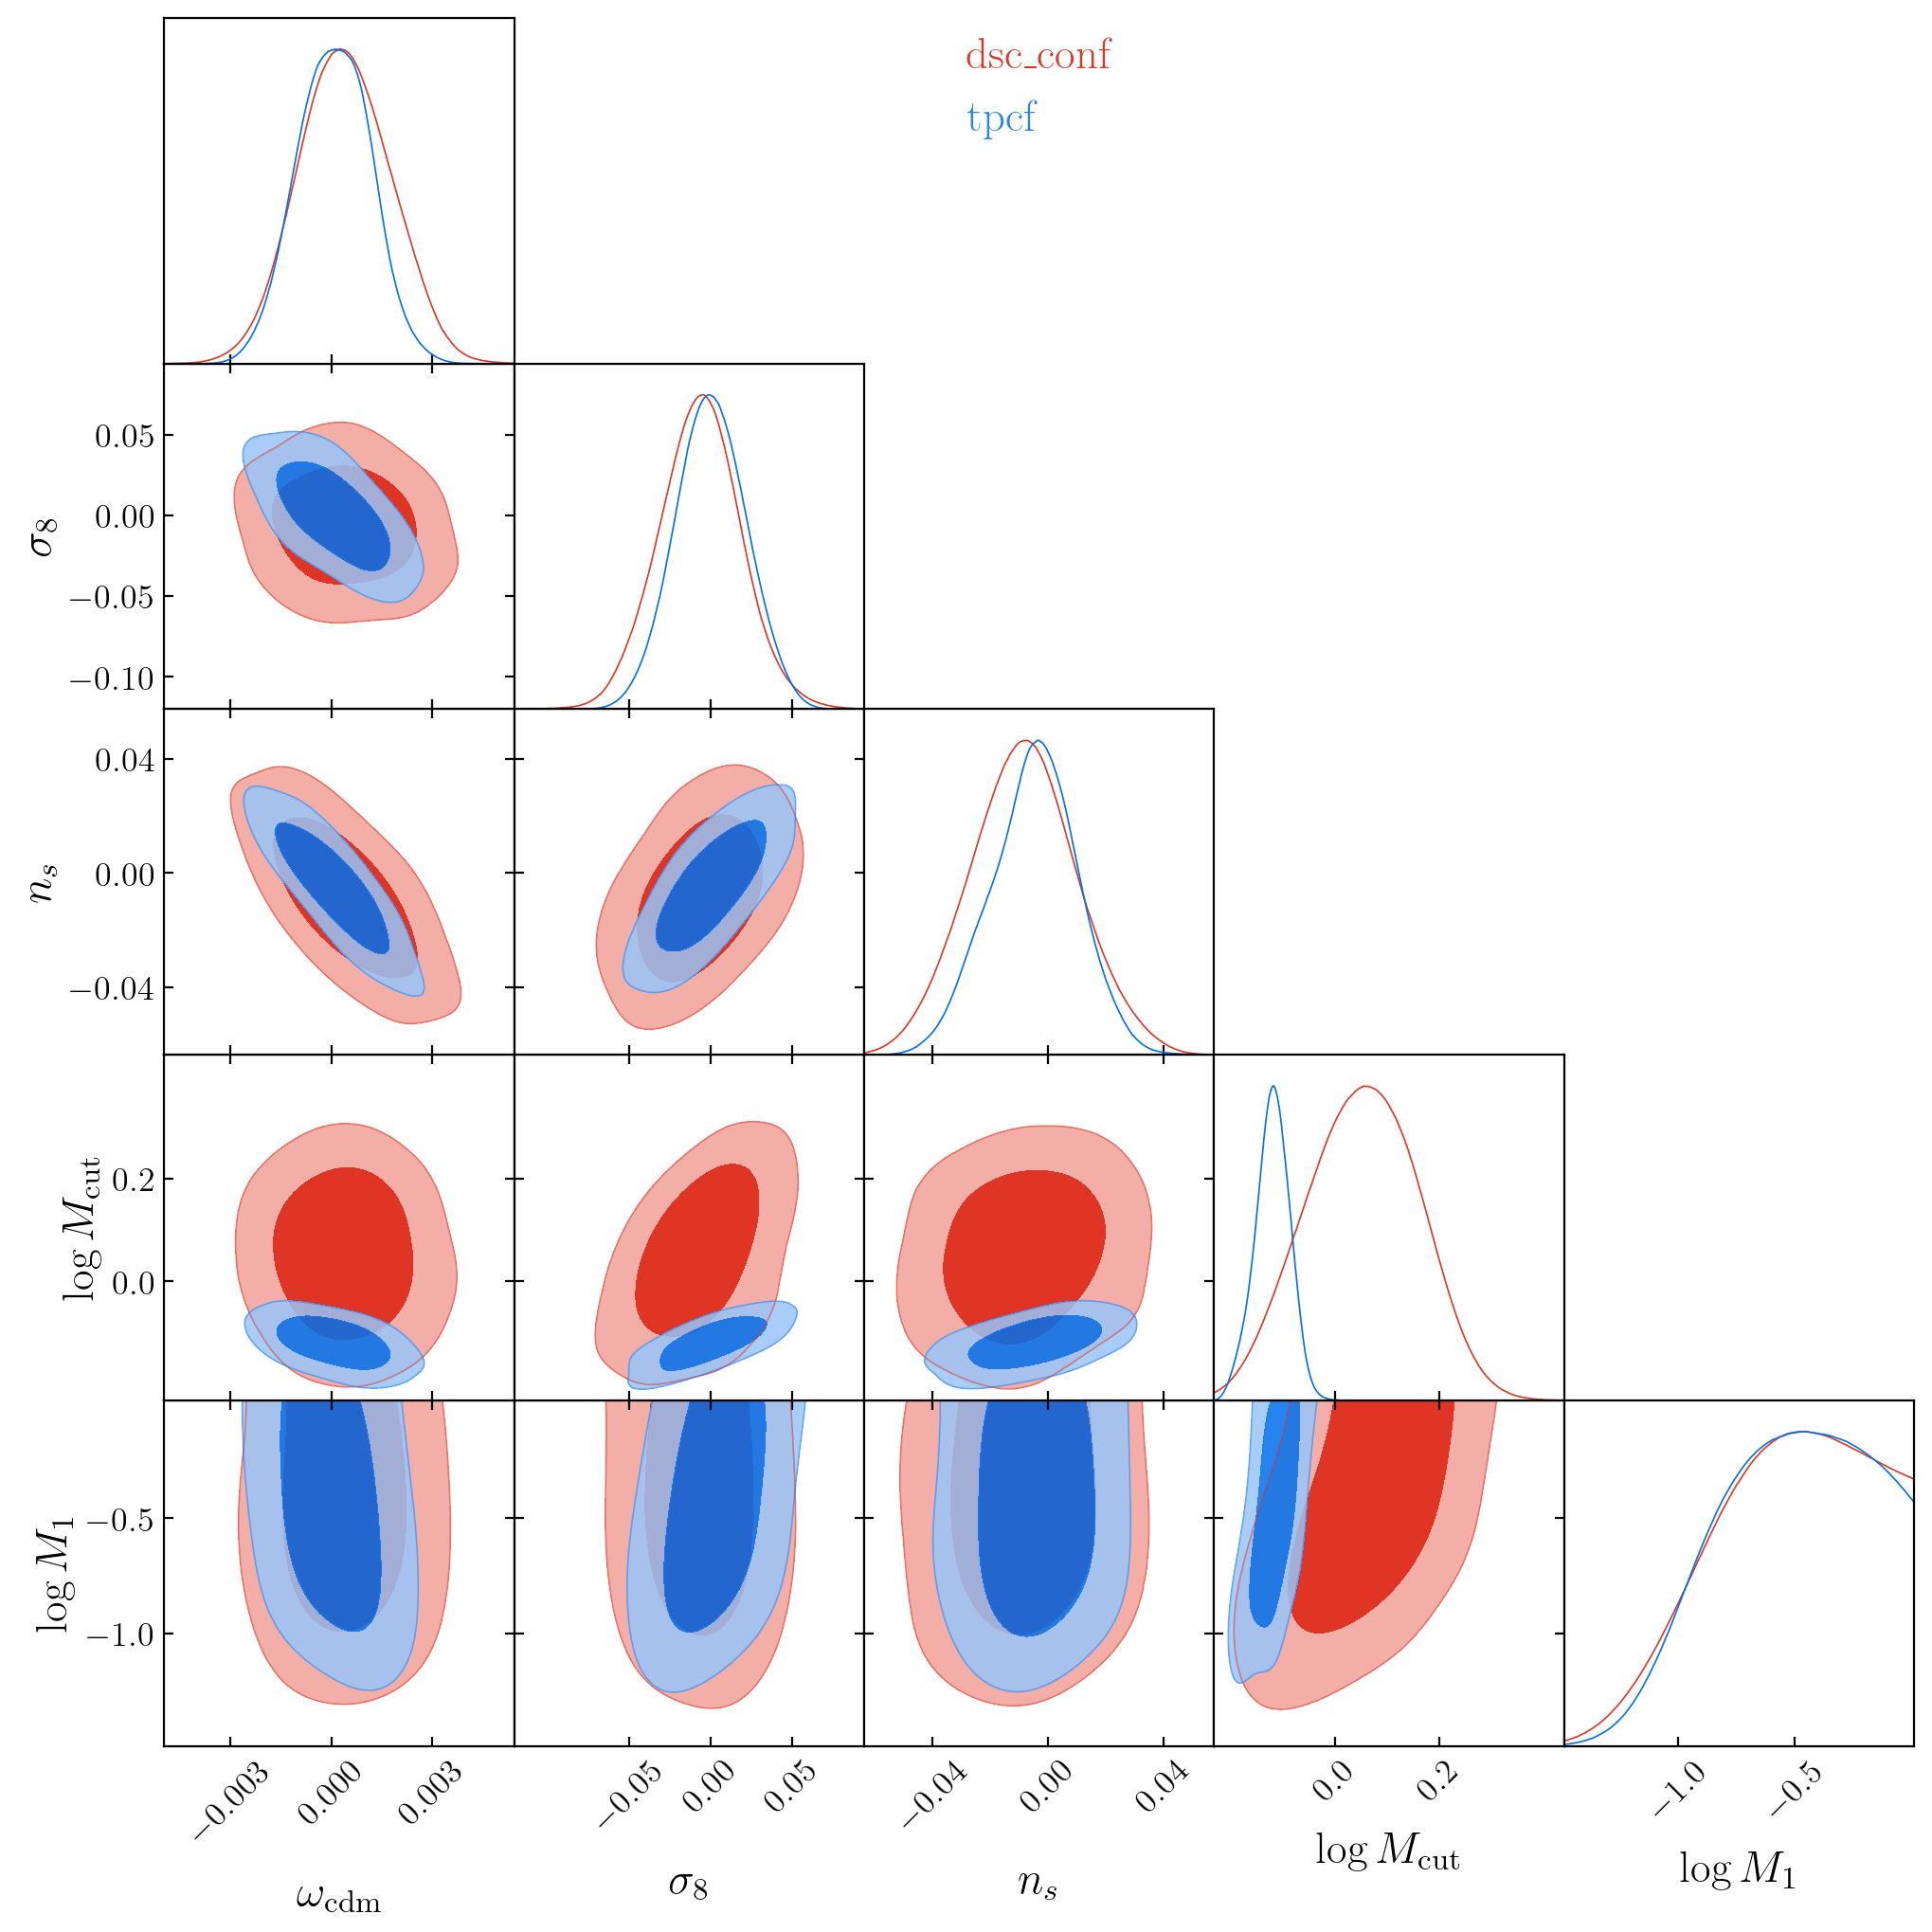

In [35]:
from getdist import plots, MCSamples
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

labels = {
    "omega_b": r"\omega_{\rm b}",
    "omega_cdm": r"\omega_{\rm cdm}",
    "sigma8_m": r"\sigma_8",
    "n_s": r"n_s",
    "nrun": r"\alpha_s",
    "N_ur": r"N_{\rm ur}",
    "w0_fld": r"w_0",
    "wa_fld": r"w_a",
    "logM_1": r"\log M_1",
    "logM_cut": r"\log M_{\rm cut}",
    "alpha": r"\alpha",
    "alpha_s": r"\alpha_{\rm vel, s}",
    "alpha_c": r"\alpha_{\rm vel, c}",
    "sigma": r"\log \sigma",
    "kappa": r"\kappa",
    "B_cen": r"B_{\rm cen}",
    "B_sat": r"B_{\rm sat}",
    "fsigma8": r"f \sigma_8",
    "Omega_m": r"\Omega_{\rm m}",
    "H0": r"H_0",
}

def read_lhc():
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/wp/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'wp_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    return data['lhc_x'], data['lhc_y'], data['lhc_x_names']

def read_lhc():
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/tpcf/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'tpcf_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    return data['lhc_x'], data['lhc_y'], data['lhc_x_names']

# stats = ['wst', 'dsc_conf', 'dsc_fourier', 'minkowski']
stats = ['dsc_conf', 'tpcf']

idx_fit = 1

chains = []

for statistic in stats:

    # load the data
    lhc_x, lhc_y, lhc_x_names = read_lhc()
    print(lhc_x_names)
    print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')
    
    truth = dict(zip(lhc_x_names, lhc_x[idx_fit]))
    
    data_fn = f'/global/homes/e/epaillas/code/acm/projects/emc/posterior_cosmo+hod_{statistic}_idx{idx_fit}.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    print(data['names'])

    for key, value in data['ranges'].items():
        data['ranges'][key] = value - truth[key]
        # data['ranges'][key] = value
    
    chains.append(
        MCSamples(
                samples=data['samples']  - [truth[name] for name in data['names']],
                # samples=data['samples'],
                weights=data['weights'],
                names=data['names'],
                ranges=data['ranges'],
                labels=[labels[n] for n in data['names']],
            )
    )
    
    
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 20
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=chains,
    legend_labels=stats,
    filled=True,
    # markers=dict(zip(lhc_x_names, lhc_x[idx_fit])),
    # markers=dict(zip(lhc_x_names, np.zeros(len(lhc_x_names)))),
    params=['omega_cdm', 'sigma8_m', 'n_s', 'logM_cut', 'logM_1'],
    # params=['logM_cut', 'logM_1']
    # legend_labels=stats
)
# plt.savefig(f'fig/posterior_test_emuerr_all_hod{idx_fit}.pdf', bbox_inches='tight')
# plt.savefig(f'fig/posterior_tpcf_hod{idx_fit}.pdf', bbox_inches='tight')